In [1]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
from PIL import Image
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm 

# --- Configuration and Setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model = fasterrcnn_resnet50_fpn(weights=weights).to(device)
model.eval()

# Directory paths configuration (Crucial Fix for RuntimeError)
img_dir = "data/VOC2007/JPEGImages/"
pseudo_dir = "data/pseudo/" 
YEAR_FOLDER = "VOC2007" 
MAX_IMAGES = 2000

# Define required VOC structure paths
voc_root_path = os.path.join(pseudo_dir, YEAR_FOLDER)
jpeg_path = os.path.join(voc_root_path, "JPEGImages")
anno_path = os.path.join(voc_root_path, "Annotations")
split_dir = os.path.join(voc_root_path, "ImageSets", "Main")

# Create necessary directories
print(f"Creating directory structure in: {voc_root_path}")
os.makedirs(jpeg_path, exist_ok=True)
os.makedirs(anno_path, exist_ok=True)
os.makedirs(split_dir, exist_ok=True)


# --- Utility Function to Save VOC XML ---
def save_voc_xml(img_path, boxes, labels, save_path):
    """Generates and saves a PASCAL VOC format XML annotation file."""
    img = Image.open(img_path)
    w, h = img.size
    
    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "folder").text = "pseudo"
    ET.SubElement(annotation, "filename").text = os.path.basename(img_path)
    
    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(w)
    ET.SubElement(size, "height").text = str(h)
    ET.SubElement(size, "depth").text = "3"
    
    for (xmin, ymin, xmax, ymax), label in zip(boxes, labels):
        obj = ET.SubElement(annotation, "object")
        ET.SubElement(obj, "name").text = label
        bndbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bndbox, "xmin").text = str(int(xmin)) 
        ET.SubElement(bndbox, "ymin").text = str(int(ymin))
        ET.SubElement(bndbox, "xmax").text = str(int(xmax))
        ET.SubElement(bndbox, "ymax").text = str(int(ymax))
    
    tree = ET.ElementTree(annotation)
    tree.write(save_path, encoding='utf-8', xml_declaration=True)


# --- Pseudo-Label Generation Loop ---
COCO_LABELS = weights.meta["categories"]
MERGE_MAP = {
    # Vehicles
    "car": "vehicle", "truck": "vehicle", "bus": "vehicle", "motorcycle": "vehicle",
    "bicycle": "vehicle", "train": "vehicle",

    # Animals
    "dog": "dog", "cat": "cat", "horse": "dog", "cow": "dog", "sheep": "dog", "elephant": "dog", "bear": "dog",

    # People
    "person": "person",
}

image_files = os.listdir(img_dir)
image_list = [] 
print(f"Starting pseudo-label generation for up to {min(len(image_files), MAX_IMAGES)} images...")

for i, img_name in enumerate(tqdm(image_files[:MAX_IMAGES], desc="Generating Pseudo-Labels")):
    img_path = os.path.join(img_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(img).to(device)
    
    with torch.no_grad():
        pred = model([img_tensor])[0]
    
    # Filter high-confidence boxes and merge labels
    threshold = 0.3
    high_confidence = pred["scores"] > threshold
    boxes = pred["boxes"][high_confidence].cpu().numpy()
    coco_indices = pred["labels"][high_confidence].cpu().numpy()
    labels = [MERGE_MAP.get(COCO_LABELS[i], COCO_LABELS[i]) for i in coco_indices]
    
    # Save the XML annotation and copy/link image
    img_id = img_name.replace(".jpg", "")
    xml_save_path = os.path.join(anno_path, img_id + ".xml")
    save_voc_xml(img_path, boxes, labels, xml_save_path)
    
    try:
        os.link(img_path, os.path.join(jpeg_path, img_name)) # Use os.link for efficiency
    except FileExistsError:
        pass # Ignore if file is already linked/copied
    
    image_list.append(img_id)

# --- Create the required train.txt split file ---
split_file_path = os.path.join(split_dir, "train.txt")
with open(split_file_path, "w") as f:
    f.write("\n".join(image_list))

print("\n--- Pseudo-Label Generation Complete ---")
print(f"Total pseudo-labels generated: {len(image_list)}")
print(f"Created PASCAL VOC split file: {split_file_path}")

Using device: cuda
Creating directory structure in: data/pseudo/VOC2007
Starting pseudo-label generation for up to 2000 images...


Generating Pseudo-Labels: 100%|████████████████████████████████████████████████████| 2000/2000 [02:31<00:00, 13.20it/s]


--- Pseudo-Label Generation Complete ---
Total pseudo-labels generated: 2000
Created PASCAL VOC split file: data/pseudo/VOC2007\ImageSets\Main\train.txt


In [5]:
# =====================================================================
# IMPORTS
# =====================================================================
from torchvision.datasets import VOCDetection
from torch.utils.data import Dataset, DataLoader
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
import torchvision.transforms.functional # Required for to_tensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # Required for model head modification
from tqdm import tqdm # Required for the progress bar

# =====================================================================
# CUSTOM DATASET CLASS
# =====================================================================
class VOCPseudo(VOCDetection):
    # NOTE: The parse_voc_xml method is expected to be inherited from VOCDetection
    # or defined in a custom base class. Assuming standard VOCDetection inheritance.
    def __init__(self, root, image_set="train", transform=None):
        self.root = root
        self.year = "2007"
        self.image_set = image_set
        self.download = False
        self.transform = transform
        self.target_transform = None
        self.transforms = None

        voc_root = os.path.join(root, "VOC2007")
        image_dir = os.path.join(voc_root, "JPEGImages")
        annotation_dir = os.path.join(voc_root, "Annotations")
        split_file = os.path.join(voc_root, "ImageSets", "Main", f"{image_set}.txt")

        # Check if the split file exists before trying to open it
        if not os.path.exists(split_file):
             # You would typically download the data or raise a more informative error here
             raise FileNotFoundError(f"Split file not found: {split_file}. Ensure VOC2007 is at {root}/VOC2007")

        with open(split_file) as f:
            self.ids = [x.strip() for x in f.readlines()]

        self.image_paths = [os.path.join(image_dir, f"{i}.jpg") for i in self.ids]
        self.annotation_paths = [os.path.join(annotation_dir, f"{i}.xml") for i in self.ids]

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        ann_path = self.annotation_paths[idx]

        img = Image.open(img_path).convert("RGB")
        
        # ET.parse requires a file path; using ET.parse(ann_path).getroot() is correct.
        target = self.parse_voc_xml(ET.parse(ann_path).getroot())

        if self.transform:
            img = self.transform(img)

        boxes, labels = [], []
        objects = target["annotation"].get("object", [])
        if not isinstance(objects, list):
            objects = [objects]

        for obj in objects:
            # Check if the object's name is in the target map before adding its bounding box
            if obj["name"] in {"vehicle", "dog", "cat"}:
                boxes.append([
                    float(obj["bndbox"]["xmin"]),
                    float(obj["bndbox"]["ymin"]),
                    float(obj["bndbox"]["xmax"]),
                    float(obj["bndbox"]["ymax"]),
                ])
                labels.append(obj["name"])

        label_map = {"vehicle": 1, "dog": 2, "cat": 3}
        
        # Only process labels and boxes that were collected (i.e., those in the label_map)
        if not labels:
            # Important: If no valid labels are found, create empty tensors.
            boxes_t = torch.zeros((0, 4), dtype=torch.float32)
            labels_t = torch.zeros((0,), dtype=torch.int64)
        else:
            labels_t = torch.tensor([label_map[l] for l in labels], dtype=torch.int64)
            boxes_t = torch.tensor(boxes, dtype=torch.float32)

        target = {"boxes": boxes_t, "labels": labels_t}
        
        # Convert PIL image to tensor (C, H, W)
        img = torchvision.transforms.functional.to_tensor(img)

        return img, target

    def __len__(self):
        return len(self.ids)

# =====================================================================
# CUSTOM COLLATE FUNCTION (FIXED)
# Fixes the 'IndexError: index is out of bounds for dimension with size 0'
# by filtering out samples with zero valid ground truth targets.
# =====================================================================
def collate_fn_with_filter(batch):
    """
    Collate function that filters out samples with zero valid targets (labels tensor is empty).
    This prevents an IndexError in the torchvision RoIHeads during training.
    """
    # 1. Filter the batch
    # A sample is valid if target["labels"] has a length > 0
    filtered_batch = [(img, target) for img, target in batch 
                      if len(target["labels"]) > 0]

    if not filtered_batch:
        # If the entire batch was filtered out, return empty tuples.
        return tuple(), tuple()

    # 2. Transpose (zip) the filtered batch
    return tuple(zip(*filtered_batch))


# =====================================================================
# SETUP
# NOTE: The variables 'model', 'device', and 'pseudo_dir' must be defined 
# in the environment prior to running this cell.
# =====================================================================
# Example placeholders (uncomment and replace with your actual setup)
# import torchvision
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# pseudo_dir = "/path/to/VOCdevkit" 


# --- Dataset and DataLoader ---
print("Initializing dataset and DataLoader...")
# Assuming 'pseudo_dir' is defined
train_dataset = VOCPseudo(pseudo_dir) 
train_loader = DataLoader(
    train_dataset, 
    batch_size=2, 
    shuffle=True, 
    collate_fn=collate_fn_with_filter # Using the fixed collate_fn
)

# --- Model Modification ---
num_classes = 4  # background (0) + vehicle (1) + dog (2) + cat (3)
print(f"Modifying model head for {num_classes-1} classes...")
# Ensure 'model' and 'device' are available from Cell 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).to(device)

# --- Training Loop ---
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 5

model.train()
print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    epoch_loss = 0.0
    # The tqdm iterator will handle cases where a batch is returned empty by the collate_fn,
    # or the length of the loader is adjusted automatically.
    for i, (imgs, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # Skip if the batch is empty (due to collate_fn filtering)
        if not imgs:
            continue
            
        imgs = list(img.to(device) for img in imgs)
        # targets is a list of dicts. Move tensors inside the dicts to the device.
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        # Forward pass and loss calculation
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
        
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} finished. Average Loss: {avg_loss:.4f}")

Initializing dataset and DataLoader...
Modifying model head for 3 classes...
Starting training for 5 epochs...


Epoch 1/5: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [02:28<00:00,  6.76it/s]


Epoch 1/5 finished. Average Loss: 0.1995


Epoch 2/5: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.51it/s]


Epoch 2/5 finished. Average Loss: 0.1452


Epoch 3/5: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.47it/s]


Epoch 3/5 finished. Average Loss: 0.1305


Epoch 4/5: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.47it/s]


Epoch 4/5 finished. Average Loss: 0.1159


Epoch 5/5: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.49it/s]

Epoch 5/5 finished. Average Loss: 0.0991


In [14]:
import cv2

new_img_dir = "data/new_images/"
results = []

model.eval()

# Wrap the iterable with tqdm for progress tracking
for img_name in tqdm(os.listdir(new_img_dir)[:1000], desc="Processing Images"):
    img_path = os.path.join(new_img_dir, img_name)
    img = cv2.imread(img_path)

    # Basic check for image loading
    if img is None:
        print(f"Warning: Could not read image at {img_path}. Skipping.")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = F.to_tensor(img_rgb).to(device)
    
    with torch.no_grad():
        # Ensure the model is called with a list of tensors
        pred = model([img_tensor])[0]
    
    boxes = pred["boxes"].cpu().numpy()
    scores = pred["scores"].cpu().numpy()
    
    # Define the label map
    IDX_TO_LABEL = {1: "vehicle", 2: "dog", 3: "cat"}
    
    # Map labels from IDs to strings, using "N/A" for unknown IDs
    labels = [IDX_TO_LABEL.get(i, "N/A") for i in pred["labels"].cpu().numpy()]
    
    results.append({
        "img": img_name,
        "boxes": boxes.tolist(),
        "labels": labels,
        "scores": scores.tolist()
    })

Processing Images: 100%|███████████████████████████████████████████████████████████| 1000/1000 [01:17<00:00, 12.99it/s]


In [15]:
import pandas as pd

all_labels = []
for r in results:
    all_labels.extend(r["labels"])

summary = pd.Series(all_labels).value_counts()
print(summary)

vehicle    3969
dog        3759
cat        1549
Name: count, dtype: int64


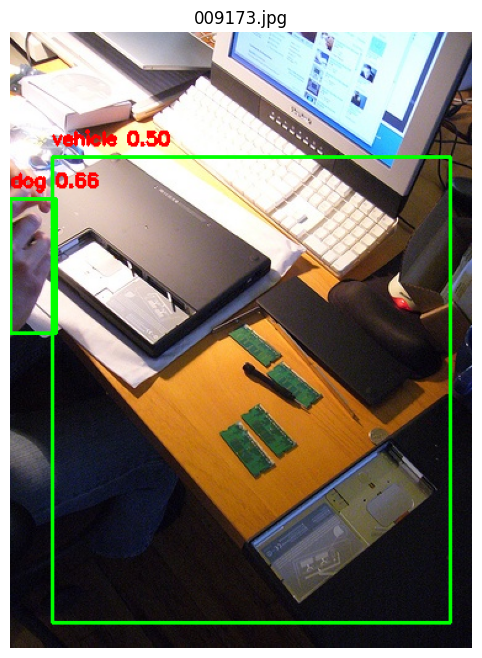

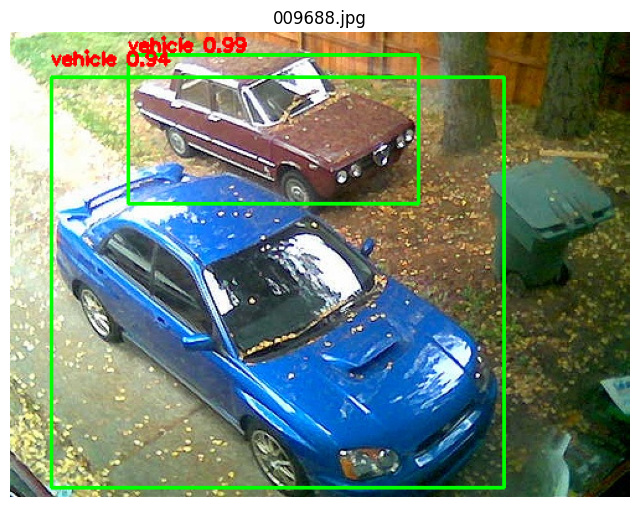

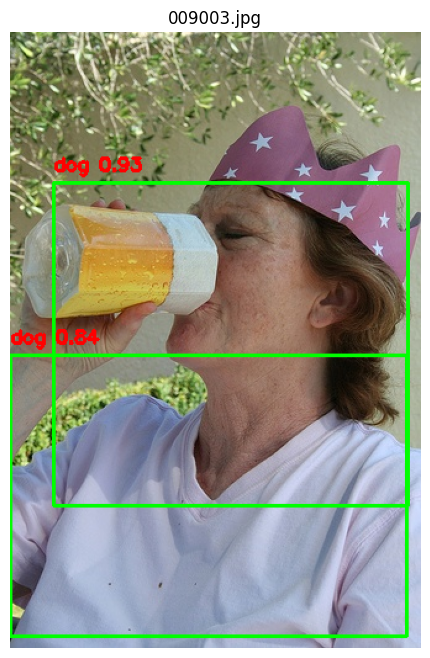

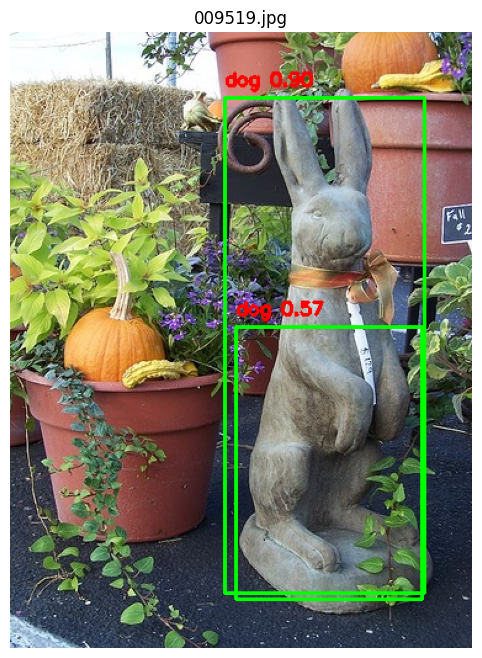

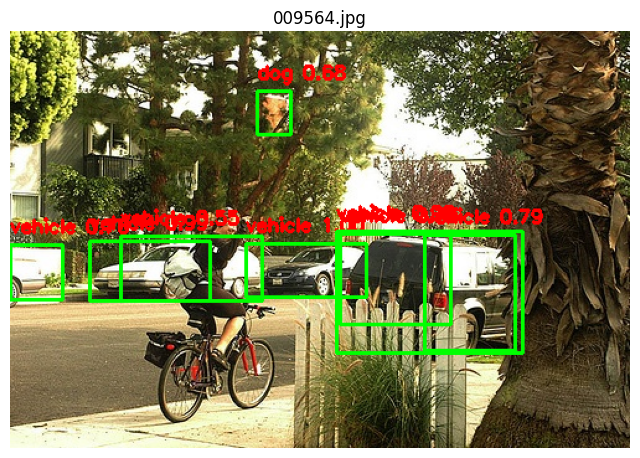

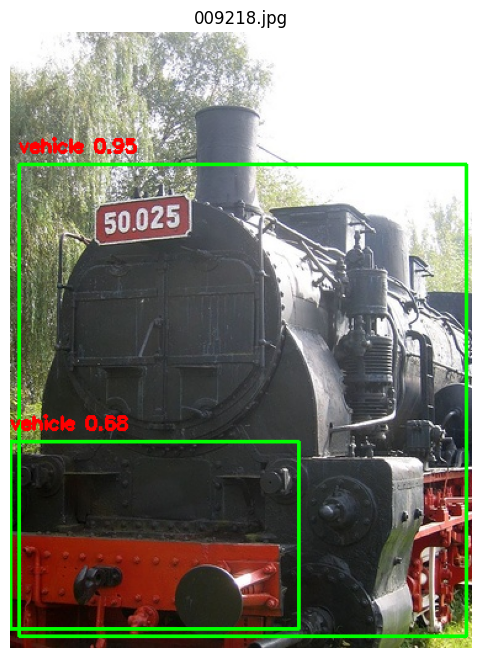

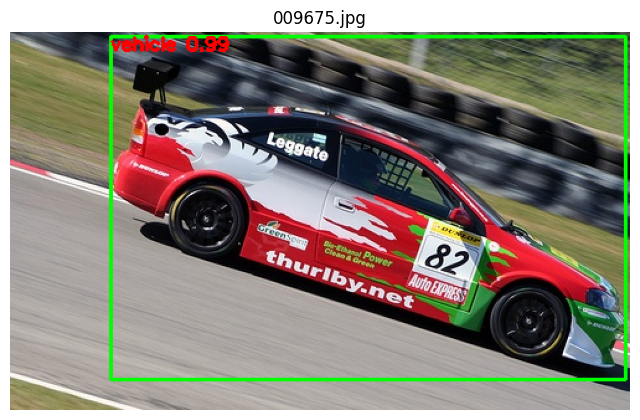

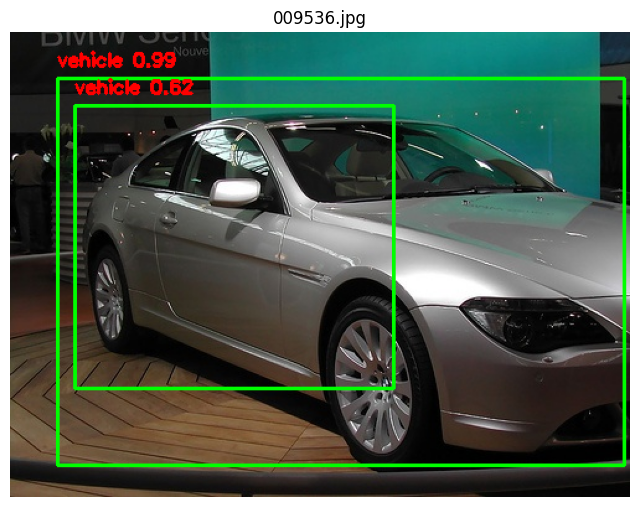

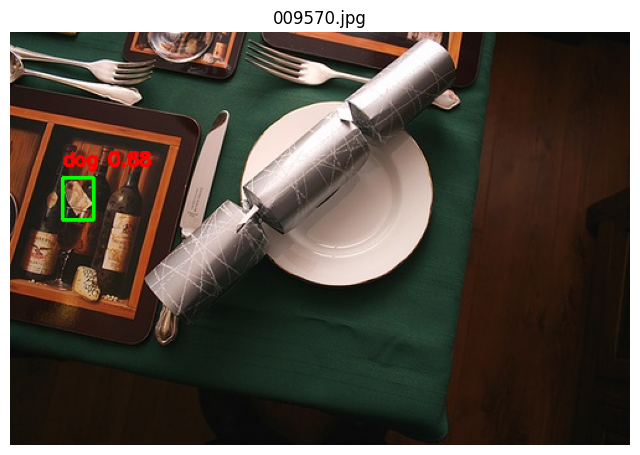

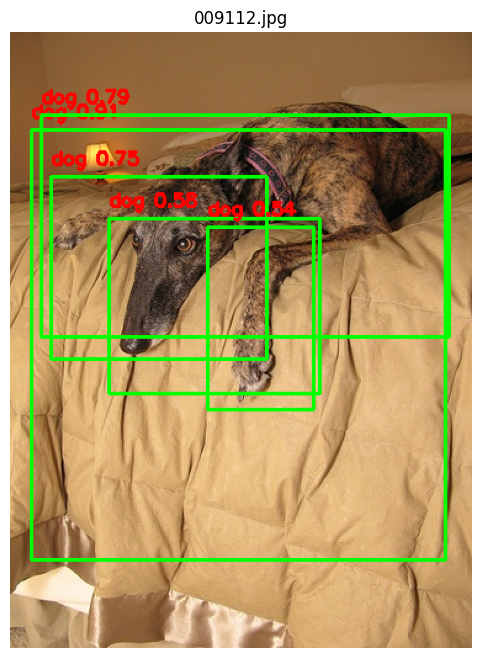

In [16]:
import random
import matplotlib.pyplot as plt
import cv2

# Pick 10 random samples
n_show = 10
sample_results = random.sample(results, min(n_show, len(results)))

for res in sample_results:
    img_path = os.path.join(new_img_dir, res["img"])
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    boxes = res["boxes"]
    labels = res["labels"]
    scores = res["scores"]
    
    # Draw boxes
    for (box, label, score) in zip(boxes, labels, scores):
        if score < 0.5:  # skip low-confidence
            continue
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        text = f"{label} {score:.2f}"
        cv2.putText(img, text, (x1, max(y1-10, 15)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    
    # Show
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(res["img"])
    plt.show()